In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [5]:
df = pd.read_csv('woojoo.csv',parse_dates = ['Datetime'])
df.head()

,Datetime,Battery Voltage,Hammer Sensor Hole and System State,Menhole cover status,TEMPERATURE,HUMIDITY,SURFACE,CO,CO2,CH4,O2,H2S
0,2021-12-01 17:37:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1131.0,0.0,19.8,0.0
1,2021-12-01 17:41:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1131.0,0.0,19.8,0.0
2,2021-12-01 17:42:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1131.0,0.0,19.8,0.0
3,2021-12-01 17:44:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1131.0,0.0,19.8,0.0
4,2021-12-01 17:44:00,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1131.0,0.0,19.8,0.0


In [6]:
df1=df[['CO']]
df1

,CO
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
62390,2.0
62391,NaN
62392,2.0
62393,NaN


In [7]:
df2=df1.dropna()
df3=df2.reset_index()
df4=df3[['CO']]
df4

,CO
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
32473,2.0
32474,2.0
32475,2.0
32476,2.0


In [8]:
df4.index = pd.to_datetime(df4.index, unit='m')
df4

,CO
1970-01-01 00:00:00,1.0
1970-01-01 00:01:00,1.0
1970-01-01 00:02:00,1.0
1970-01-01 00:03:00,1.0
1970-01-01 00:04:00,1.0
...,...
1970-01-23 13:13:00,2.0
1970-01-23 13:14:00,2.0
1970-01-23 13:15:00,2.0
1970-01-23 13:16:00,2.0


In [9]:
df5=df4.resample('30S').ffill()
df5

,CO
1970-01-01 00:00:00,1.0
1970-01-01 00:00:30,1.0
1970-01-01 00:01:00,1.0
1970-01-01 00:01:30,1.0
1970-01-01 00:02:00,1.0
...,...
1970-01-23 13:15:00,2.0
1970-01-23 13:15:30,2.0
1970-01-23 13:16:00,2.0
1970-01-23 13:16:30,2.0


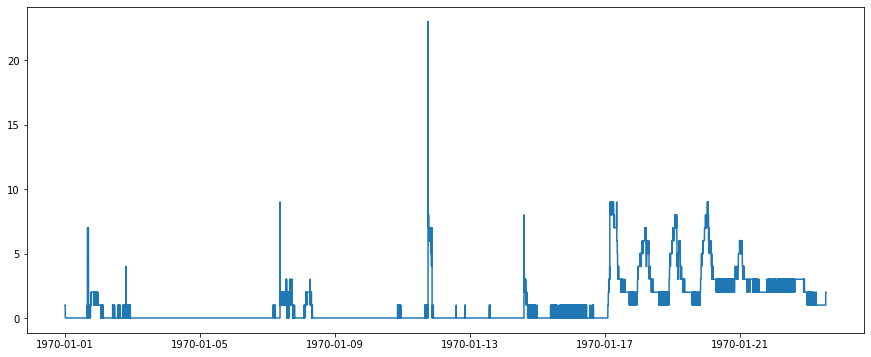

In [11]:
# df1['CO2'].interpolate(method='linear', inplace=True)
plt.figure(figsize = (15, 6))
plt.plot(df5.index, df5['CO'])

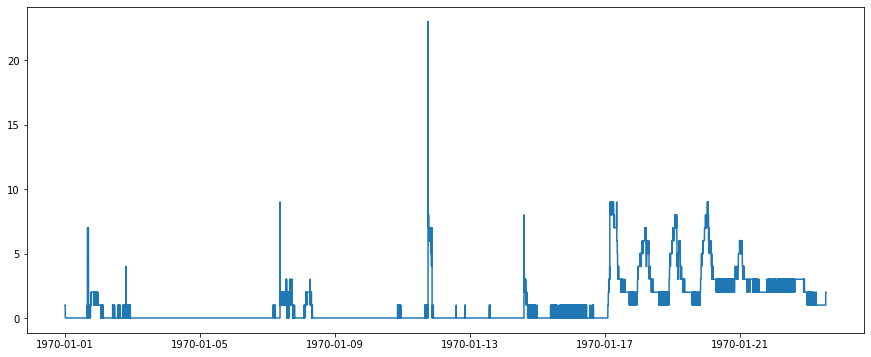

In [13]:
df5['CO'].fillna(value=None, method='backfill', axis=None, limit=None, downcast=None,inplace=True)
plt.figure(figsize = (15, 6))
plt.plot(df5.index, df5['CO'])

In [14]:
df6=df5

In [15]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

In [16]:
def split_sequence(sequence, n_steps):
    X, y =list(),list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [17]:
train_size = int(len(df6)*0.8)
train_data = df6.iloc[:train_size]
test_data = df6.iloc[train_size:]

In [18]:
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [19]:
train_scaled.shape

(51964, 1)

In [20]:
test_scaled.shape

(12991, 1)

In [21]:
col_train=train_scaled[:,0]
# seq_train=col_train.values
raw_seq_train=col_train.tolist()

In [22]:
len(raw_seq_train)

51964

In [23]:
col_test=test_scaled[:,0]
# seq_test=col_test.values
raw_seq_test=col_test.tolist()

In [24]:
len(raw_seq_test)

12991

In [25]:
from sklearn.model_selection import train_test_split
n_steps = 30
X_train, y_train = split_sequence(raw_seq_train, n_steps)
X_test, y_test = split_sequence(raw_seq_test, n_steps)

In [26]:
type(y_train)

numpy.ndarray

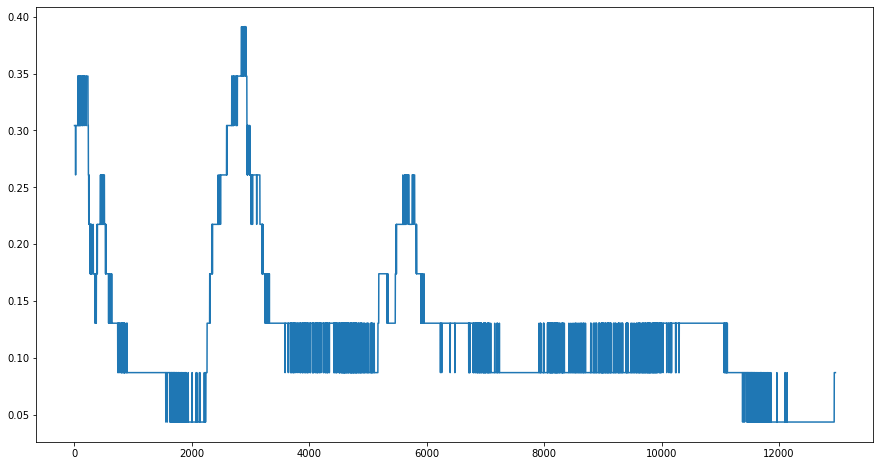

In [27]:
plt.figure(figsize=(15, 8))
range_future = len(y_test)
plt.plot(np.arange(range_future), np.array(y_test),  label='Test data')

In [28]:
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51934, 30)
(51934, 1)
(12961, 30)
(12961, 1)


In [30]:
n_features = 1
n_seq = 15
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test= X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51934, 15, 1, 2, 1)
(51934, 1)
(12961, 15, 1, 2, 1)
(12961, 1)


In [32]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [113]:
# def fit_model(model):
#     early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
#                                                patience = 10)
#     history = model.fit(X, y, epochs = 5, verbose=0)
#                         #validation_split = 0.2,
#                         #batch_size = 16, shuffle = False, 
#                         #callbacks = [early_stop])
#     return history

In [33]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs = 5, verbose=0,
                     validation_split = 0.2,
                     batch_size = 16)
    return history

In [34]:
history_convlstm=fit_model(model)
history_convlstm

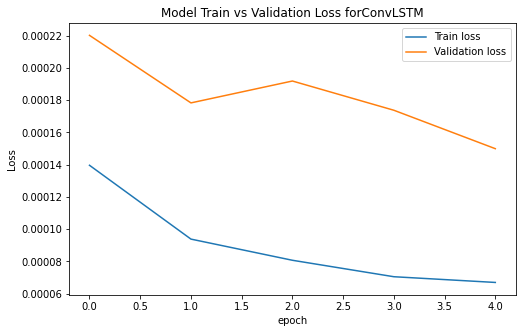

In [35]:
def plot_loss (history, model_name):
    plt.figure(figsize = (8, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for'+ model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_convlstm, 'ConvLSTM')

In [36]:
def prediction(model):
    prediction = model.predict(X_test)
#     prediction = scaler.inverse_transform(prediction)
    return prediction
prediction= prediction(model)
prediction

array([[0.3067016 ],
       [0.3067016 ],
       [0.3067016 ],
       ...,
       [0.08940959],
       [0.08920328],
       [0.08940233]], dtype=float32)

In [37]:
len(prediction)

12961

In [38]:
y_test

array([[0.30434783],
       [0.30434783],
       [0.30434783],
       ...,
       [0.08695652],
       [0.08695652],
       [0.08695652]])

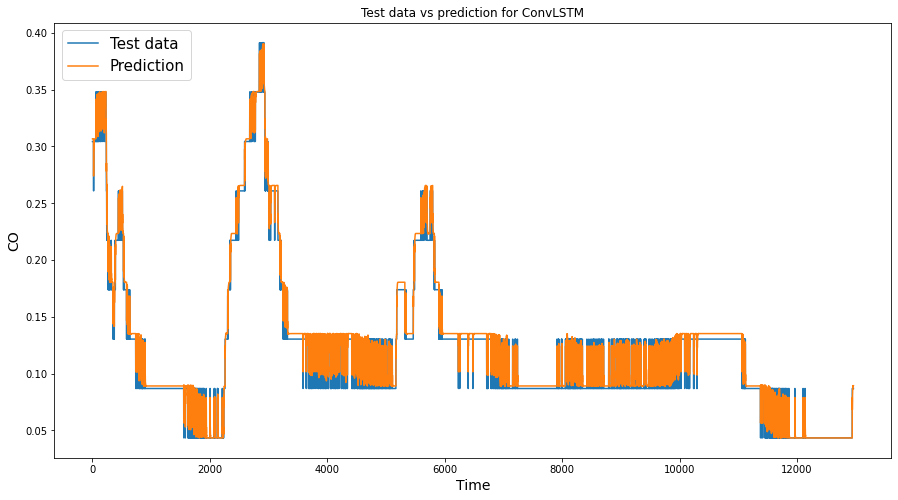

In [43]:
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(15, 8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),  label='Test data')
    plt.plot(np.arange(range_future),np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left',fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('CO',fontsize=14)

plot_future(prediction,'ConvLSTM', y_test)

In [40]:
def evaluate_prediction(predictions, actual, model_name):
    dif=predictions-actual
    errors = np.nan_to_num(dif, nan=0)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Square Error: {:.4f}'.format(mse))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute  Error: {:.4f}'.format(mae))
    return errors, mse, rmse, mae

errors, mse, rmse, mae= evaluate_prediction(prediction, y_test, 'ConvLSTM')

ConvLSTM:
Mean Square Error: 0.0001
Root Mean Square Error: 0.0115
Mean Absolute  Error: 0.0067


In [42]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
mae = mean_absolute_error(y_test,prediction)
mse = mean_squared_error(y_test,prediction)
rmse=sqrt(mse)
print('Mean Square Error: {:.4f}'.format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute  Error: {:.4f}'.format(mae))



Mean Square Error: 0.0001
Root Mean Square Error: 0.0115
Mean Absolute  Error: 0.0067
